# Linear Augmentation of Data

This notebook is a demonstration of how linear augmentation of data is made both for intensity data and feature occurrence data.

As an example, the grapevine dataset 'vitis_types' is used.

Notebook organization:
- Reading and treating Grapevine data (and storing as a dataset)
- Generating Linearly Generated Intensity and Feature Occurrence Data
- Analyze the Generated Data compared to the experimental Grapevine Data

#### Needed Imports

In [1]:
import itertools
from pathlib import Path

# json for persistence
import json
from time import perf_counter

import numpy as np
import pandas as pd
from pandas.testing import assert_frame_equal

import scipy.spatial.distance as dist
import scipy.cluster.hierarchy as hier
import scipy.stats as stats

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from matplotlib import ticker

import seaborn as sns
from collections import namedtuple, Counter

import sklearn.ensemble as skensemble
from sklearn.model_selection import GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import (mean_squared_error, r2_score, roc_auc_score, roc_curve, auc)

from tqdm import tqdm
from IPython import display as ipythondisplay

# Metabolinks package
import metabolinks as mtl
import metabolinks.transformations as transf

import gan_evaluation_metrics as gem

# Python files in the repository
import multianalysis as ma
from elips import plot_confidence_ellipse

In [2]:
%matplotlib inline

Reading the grapevine data to be analysed and augmented

In [4]:
datasets = {}
# From the alignments_new store

# GD_neg_global2 (GDg2-)
#data_df = pd.HDFStore('alignments_new.h5').get('all_1ppm_min2_neg').transpose()
data_df = pd.read_csv('store_data/exp_data.csv', index_col=[0,1])
gd_labels = mtl.parse_data(data_df, labels_loc='label').sample_labels


# GD_neg_class2 (GDc2-)
#data_df = pd.HDFStore('alignments_new.h5').get('groups_1ppm_min2_all_1ppm_neg').transpose()
#gd_labels = mtl.parse_data(data_df, labels_loc='label').sample_labels

# vitis_types (GD types)
vitis_types = {'CAN': 'wild', 'RIP': 'wild', 'ROT': 'wild','RU': 'wild', 'LAB': 'wild',
               'SYL': 'wild','REG': 'vinifera','CS': 'vinifera','PN': 'vinifera','RL': 'vinifera',
               'TRI': 'vinifera'}

gd_type_labels = [vitis_types[lbl] for lbl in gd_labels]

datasets['vitis_types'] = {'source': 'grapevine',
                            'mode': '-',
                            'name': 'GD types',
                            'data': data_df.copy(),
                            'target': gd_type_labels,
                            'classes': list(pd.unique(gd_type_labels))}

print('------\ntarget for 2-class wild Vitis vs Vitis vinifera data set')
print(datasets['vitis_types']['target'])

------
target for 2-class wild Vitis vs Vitis vinifera data set
['wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'wild', 'vinifera', 'vinifera', 'vinifera']


In [5]:
datasets['vitis_types']['data'].columns = [float(i) for i in datasets['vitis_types']['data'].columns]

2 classes of Vitis types (wild and _vinifera_)

In [6]:
# customize label colors for 2 types of Vitis varieties

colours = [sns.color_palette('Greens', 3)[2], sns.color_palette('flare', 5)[4]]
vitis_type_classes = datasets['vitis_types']['classes']
vitis_types_label_colors = {lbl: c for lbl, c in zip(vitis_type_classes, colours)}
datasets['vitis_types']['label_colors'] = vitis_types_label_colors
datasets['vitis_types']['sample_colors'] = [vitis_types_label_colors[lbl] for lbl in datasets['vitis_types']['target']]

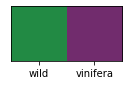

In [7]:
sns.palplot(datasets['vitis_types']['label_colors'].values())
new_ticks = plt.xticks(range(len(datasets['vitis_types']['classes'])), datasets['vitis_types']['classes'])

Perform pre-treatment on the data and store original and NGP pre-treated data

NGP - Normalization by the reference feature Leucine Enkephalin, Generalized Logarithmic Transformation and Pareto Scaling.

In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold

def impute_RF(df, nearest_features=100, n_trees=10, max_iter=10):
    rf_estimator = ExtraTreesRegressor(n_estimators=n_trees)
    imputer = IterativeImputer(random_state=0, estimator=rf_estimator,
                           n_nearest_features=nearest_features, min_value=0.0,
                           verbose=0,
                           max_iter=max_iter)
    imputed_data = imputer.fit_transform(df)
    return pd.DataFrame(imputed_data, index=df.index, columns=df.columns)

In [9]:
# Represents Binary Simplification pre-treatment
def df_to_bool(df):
    "Transforms data into 'binary' matrices."
    return df.mask(df.notnull(), 1).mask(df.isnull(), 0)

# Performs all pre-treatment combinations mentioned
def compute_transf(dataset, norm_ref=None, lamb=None):
    "Computes 3 combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data'].copy()
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Imputation by RF
    datacols = data.columns
    data.columns = [str(col) for col in data.columns]
    imputedRF = impute_RF(data, nearest_features=100, n_trees=10)
    imputedRF.columns = datacols

    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Normalization by a reference feature RF
    if norm_ref is not None:
        normRF = transf.normalize_ref_feature(imputedRF, norm_ref, remove=True)
    else:
        normRF = imputedRF
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))

    # Pareto Scaling and Generalized Logarithmic Transformation
    P_RF = transf.pareto_scale(imputedRF)
    NP_RF = transf.pareto_scale(normRF)
    NGP_RF = transf.pareto_scale(transf.glog(normRF, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP
    
    dataset['Ionly_RF'] = imputedRF
    dataset['P_RF'] = P_RF
    dataset['NP_RF'] = NP_RF
    dataset['NGP_RF'] = NGP_RF    

In [10]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
# Theoretical mass for positive mode Leucine Enkephalin - 556.276575
Leu_Enk_neg = 554.262022
Leu_Enk_pos = 556.276575

dataset_name = datasets['vitis_types']["name"]
print(f'Applying pre-processing transformations', end=' ...')
start = perf_counter()

ref_variable = Leu_Enk_neg if datasets['vitis_types']['mode'] == '-' else Leu_Enk_pos

compute_transf(datasets['vitis_types'], norm_ref=ref_variable)

end = perf_counter()

print(f'done! took {(end - start):.3f} s')

Applying pre-processing transformations ...

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


done! took 245.313 s


C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Floa

In [11]:
# Store Experimental Data
datasets['vitis_types']['data'].to_csv('store_data/exp_data.csv')
datasets['vitis_types']['NGP'].to_csv('store_data/exp_data_NGP.csv')


In [12]:
# Altered version of compute_transf to take into account training and testing sets
def compute_transf_iterations(dataset, norm_ref=None, lamb=None, train=True):
    "Computes different combinations of pre-treatments and BinSim and returns after treatment datasets in a dict."
    
    data = dataset['data'].copy()
    data = data.dropna(how='all', axis=1)
    
    # Imputation of Missing Values
    imputed = transf.fillna_frac_min(data, fraction=0.5)
    
    # Imputation by RF
    # If training set, keep only features that appear at least in 2 samples
    if train:
        data_temp = transf.keep_atleast(data, minimum=2)
    # If test set, separate data between features that appear in at least 2 samples and those that only appear in 1.
    # Treat the data that only appears in 1 sample with 1/2 min imputation.
    # Treat the rest of the data normally with RF Imputation as with the training set.
    # Then re-join the two sets of data
    else:
        data_temp = transf.keep_atleast(data, minimum=2)
        remaining_data = data[np.setdiff1d(data.columns,data_temp.columns)]
        remaining_data = transf.fillna_frac_min(remaining_data, fraction=0.5)

    datacols = data_temp.columns
    data_temp.columns = [str(col) for col in data_temp.columns]
    #print(data)
    imputedRF = impute_RF(data_temp, nearest_features=100, n_trees=10, max_iter=2)
    imputedRF.columns = datacols
    # Join the split data
    if not train:
        imputedRF = pd.concat((imputedRF, remaining_data), axis=1)
    
    # Normalization by a reference feature
    if norm_ref is not None:
        norm = transf.normalize_ref_feature(imputed, norm_ref, remove=True)
    else:
        norm = imputed
    
    # Normalization by a reference feature RF
    if norm_ref is not None:
        normRF = transf.normalize_ref_feature(imputedRF, norm_ref, remove=True)
    else:
        normRF = imputedRF
    
    # Pareto Scaling and Generalized Logarithmic Transformation
    P = transf.pareto_scale(imputed)
    NP = transf.pareto_scale(norm)
    NGP = transf.pareto_scale(transf.glog(norm, lamb=lamb))

    # Pareto Scaling and Generalized Logarithmic Transformation
    P_RF = transf.pareto_scale(imputedRF)
    NP_RF = transf.pareto_scale(normRF)
    NGP_RF = transf.pareto_scale(transf.glog(normRF, lamb=lamb))
    
    # Store results
    dataset['BinSim'] = df_to_bool(data)
    dataset['Ionly'] = imputed
    dataset['P'] = P
    dataset['NP'] = NP
    dataset['NGP'] = NGP
    
    dataset['Ionly_RF'] = imputedRF
    dataset['P_RF'] = P_RF
    dataset['NP_RF'] = NP_RF
    dataset['NGP_RF'] = NGP_RF    

In [13]:
# Number of iterations that will be used for cross-validation
iter_num = 5

for name, ds in datasets.items():
    start2 = perf_counter()
    # Set up the place where data will be stored
    ds['iter_fold_splits'] = {}
    
    # Set up ref_variable for normalization
    if name.startswith('YD'):
        ref_variable = leu_enk_name
    else:
        ref_variable = Leu_Enk_neg if ds['mode'] == '-' else Leu_Enk_pos
    
    # In each iteration
    for n_iter in range(iter_num):
        n_fold = 5 if name == 'vitis_types' else 3
        kf = StratifiedKFold(n_fold, shuffle=True, random_state=45*(n_iter+1))
        
        # Set up different storages
        ds['iter_fold_splits'][n_iter+1] = {}
        test_dict = ds['iter_fold_splits'][n_iter+1]
        test_dict['train'] = {} # For training set
        test_dict['test'] = {} # For test set
        fold = 1
        start = perf_counter()
        
        # Generate each fold of training and test sets for each iteration, treat them and store them
        for train_index, test_index in kf.split(ds['data'], ds['target']):
            
            # Generating
            test_dict['train'][fold] = {}
            test_dict['test'][fold] = {}
            test_dict['train'][fold]['data'], test_dict['test'][fold]['data'] = ds['data'].iloc[
                train_index, :], ds['data'].iloc[test_index, :]
            test_dict['train'][fold]['target'], test_dict['test'][fold]['target'] = [
                ds['target'][i] for i in train_index], [ds['target'][i] for i in test_index]
            
            # Treating
            compute_transf_iterations(test_dict['train'][fold], norm_ref=ref_variable, train=True)
            compute_transf_iterations(test_dict['test'][fold], norm_ref=ref_variable, train=False)
            
            # Adding features that do not appear in the test data but appear in the training data to the test data
            # with the minimum value of said feature in the training data 
            train_cols = test_dict['train'][fold]['data'].dropna(how='all', axis=1).columns
            test_cols = test_dict['test'][fold]['data'].dropna(how='all', axis=1).columns
            cols_to_add = np.setdiff1d(train_cols,test_cols)
            
            for treat in ('BinSim','Ionly', 'P', 'NP', 'NGP', 'Ionly_RF', 'P_RF', 'NP_RF', 'NGP_RF'):
                test_numb = len(test_dict['test'][fold][treat])
                df_prep = []
                if treat == 'BinSim':
                    df_prep = [0.0]*len(cols_to_add)
                else:
                    for i in cols_to_add:
                        df_prep.append(min(test_dict['train'][fold][treat][i]))

                df = test_dict['test'][fold][treat].copy()
                df = pd.concat((test_dict['test'][fold][treat], 
                                pd.DataFrame((df_prep, ) * test_numb, 
                                             index=df.index, columns=cols_to_add)), axis=1)
                test_dict['test'][fold][treat] = df[
                    test_dict['train'][fold][treat].columns]

            fold = fold+1

        #ds['iter_fold_splits'][n_iter+1] = test_dict
        end = perf_counter()
        print(name, n_iter+1, f' iteration done! took {(end - start):.3f} s')
    
    end2 = perf_counter()
    print(name, f' dataset done! took {(end2 - start2):.3f} s!!')

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

vitis_types 1  iteration done! took 284.485 s


C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

vitis_types 2  iteration done! took 290.054 s


C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

vitis_types 3  iteration done! took 289.369 s


C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

vitis_types 4  iteration done! took 278.739 s


C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

C:\Users\franc\anaconda3\lib\site-packages\sklearn\impute\_iterative.py:700: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.

vitis_types 5  iteration done! took 279.221 s
vitis_types  dataset done! took 1421.869 s!!


In [14]:
# ensure dir exists
path = Path.cwd() / "store_data"
path.mkdir(parents=True, exist_ok=True)

storepath = Path.cwd() / "store_data" / 'processed_data_GD.h5'

store = pd.HDFStore(storepath, complevel=9, complib="blosc:blosclz")
#pd.set_option('io.hdf.default_format','table')

# keep json serializable values and store dataFrames in HDF store

serializable = {}

for dskey, dataset in datasets.items():
    serializable[dskey] = {}
    for key, value in dataset.items():
        #print(dskey, key)
        if isinstance(value, pd.DataFrame):
            storekey = dskey + '_' + key
            #print('-----', storekey)
            store[storekey] = value
            serializable[dskey][key] = f"INSTORE_{storekey}"
        # Save the special case of 'iter_fold_splits' that contain nested dicts until reaching DataFrames
        elif key == 'iter_fold_splits':
            for iteration, i in value.items():
                for group, n in i.items():
                    for fold, j in n.items():
                        #print(j)
                        for treat, dfs in j.items():
                            # 'AA_' serves as a special separation to identify when reading back the file
                            storekey = dskey + '_' + key + 'AA_' + str(iteration) + '_' + group + '_' + str(fold) + '_' + treat
                            if treat == 'target':
                                serializable[dskey][storekey] = dfs
                            else:
                                store[storekey] = dfs
                                serializable[dskey][storekey] = f"INSTORE_{storekey}"
            #print(dskey + '_' + key + '_' + str(value.keys()))
            #datasets['GD_neg_class2']['iter_fold_splits'][15]['train'][2]['NGP_RF']
        else:
            serializable[dskey][key] = value
store.close()
            

path = path / 'processed_data_GD.json'
with open(path, "w", encoding='utf8') as write_file:
    json.dump(serializable, write_file)

#serializable

In [15]:
path = Path.cwd() / "store_data" / 'processed_data_GD.json'
storepath = Path.cwd() / "store_data" / 'processed_data_GD.h5'
with pd.HDFStore(storepath) as store:

    with open(path, encoding='utf8') as read_file:
        datasets = json.load(read_file)
    
    for dskey, dataset in datasets.items():
        dataset['iter_fold_splits'] = {}
        for key in dataset:
            #if 'iter_fold_splits' == key:
             #   continue
            value = dataset[key]
            if isinstance(value, str) and value.startswith("INSTORE"):
                storekey = value.split("_", 1)[1]
                # Load the data from 'iter_fold_splits' carefully restoring the nested dictionaries
                if len(storekey.split("AA_")) > 1: # This separation was made to identify the 'iter_fold_splits' data
                    dictkeys = (storekey.split("AA_")[1]).split('_',3)
               #     if int(dictkeys[0]) not in dataset['iter_fold_splits'].keys():
               #         dataset['iter_fold_splits'][int(dictkeys[0])] = {}
               #     if dictkeys[1] not in dataset['iter_fold_splits'][int(dictkeys[0])].keys():
               #         dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]] = {}
               #     if int(dictkeys[2]) not in dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]].keys():
               #         dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])] = {}
               #     dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = store[storekey]

                else:
                    dataset[key] = store[storekey]
                
            # convert colors to tuples, since they are read as lists from json file
            elif key == 'label_colors':
                dataset[key] = {lbl: tuple(c) for lbl, c in value.items()}
            elif key == 'sample_colors':
                dataset[key] = [tuple(c) for c in value]
            elif key.endswith('target') and key.startswith(dskey):
                dictkeys = ((key.split("_", 1)[1]).split("AA_")[1]).split('_',3)
                dataset['iter_fold_splits'][int(dictkeys[0])][dictkeys[1]][int(dictkeys[2])][dictkeys[3]] = value

In [16]:
datasets['GD_neg_global2']['data'].to_csv('store_data/exp_data.csv')
#datasets['vitis_types']['NGP'].to_csv('store_data/exp_data_NGP.csv')

In [17]:
datasets['GD_neg_global2']['data']#.loc['BY0_1']

97.248200   97.588700   97.588885   97.590015   97.590200   \
label                                                                  
CAN   14         NaN         NaN   1557223.0         NaN   1031039.0   
      15         NaN         NaN    468344.0         NaN    321586.0   
      16    293423.0         NaN   2070914.0         NaN         NaN   
CS    29         NaN         NaN   1451682.0         NaN    726879.0   
      30    295172.0         NaN   1980895.0         NaN   1021593.0   
      31         NaN         NaN   1453977.0         NaN    724833.0   
LAB   8          NaN         NaN    636114.0         NaN         NaN   
      9          NaN         NaN    998914.0         NaN         NaN   
      10         NaN         NaN   1257923.0         NaN         NaN   
PN    23         NaN         NaN    709044.0         NaN         NaN   
      24         NaN         NaN    940835.0         NaN         NaN   
      25         NaN         NaN    894746.0         NaN         NaN   
REG   38         NaN   1073218.0         NaN    637830.0         NaN   
      39         NaN   1049440.0         NaN    534900.0         NaN   
      40         NaN   1058971.0         NaN    582966.0         NaN   
RIP   17         NaN         NaN         NaN         NaN         NaN   
      18         NaN         NaN         NaN         NaN         NaN   
      19         NaN         NaN         NaN         NaN         NaN   
RL    26         NaN    547566.0         NaN         NaN         NaN   
      27         NaN    800618.0         NaN         NaN         NaN   
      28         NaN         NaN    585964.0         NaN         NaN   
ROT   20         NaN         NaN         NaN         NaN         NaN   
      21         NaN         NaN         NaN         NaN         NaN   
      22         NaN         NaN         NaN         NaN         NaN   
RU    35         NaN    910024.0         NaN         NaN         NaN   
      36         NaN    874766.0         NaN    517917.0         NaN   
      37         NaN    908689.0         NaN    611885.0         NaN   
SYL   11    436975.0         NaN   2838014.0         NaN   1233000.0   
      12         NaN         NaN   2469917.0         NaN   1674475.0   
      13         NaN         NaN   1965553.0         NaN   1101072.0   
TRI   32         NaN   2351567.0         NaN   1440216.0         NaN   
      33         NaN   1909877.0         NaN   1124346.0         NaN   
      34         NaN   2197036.0         NaN   1421899.0         NaN   

          97.590950   97.591880   97.729920   98.153385   98.195875   ...  \
label                                                                 ...   
CAN   14         NaN    903612.0         NaN         NaN         NaN  ...   
      15         NaN    296777.0         NaN         NaN         NaN  ...   
      16         NaN    916971.0         NaN         NaN         NaN  ...   
CS    29    538425.0    631419.0         NaN         NaN         NaN  ...   
      30         NaN    738122.0         NaN         NaN         NaN  ...   
      31         NaN    704010.0         NaN         NaN         NaN  ...   
LAB   8          NaN    331444.0         NaN    293605.0         NaN  ...   
      9          NaN    530601.0         NaN         NaN         NaN  ...   
      10         NaN    538030.0         NaN         NaN    298442.0  ...   
PN    23         NaN         NaN         NaN         NaN         NaN  ...   
      24         NaN    318870.0         NaN         NaN         NaN  ...   
      25         NaN         NaN         NaN         NaN         NaN  ...   
REG   38         NaN    460092.0         NaN         NaN         NaN  ...   
      39         NaN    486631.0         NaN         NaN         NaN  ...   
      40         NaN         NaN    506345.0         NaN         NaN  ...   
RIP   17         NaN         NaN         NaN         NaN         NaN  ...   
      18         NaN         NaN         NaN         NaN         NaN  ...   
      19         NaN      

### Functions for linear augmentation of data

Present in linear_augmentation_functions.py.

In [21]:
import linear_augmentation_functions as laf

### Linear Augmentation for Intensity Data - Example

In [24]:
start = perf_counter()
data, lbls = laf.artificial_dataset_generator(datasets['vitis_types']['Ionly'], labels=datasets['vitis_types']['target'],
                                        max_new_samples_per_label=512, binary=False, rnd=list(np.linspace(0.1,0.9,9)), 
                                        binary_rnd_state=None, rnd_state=None)
end = perf_counter()
print(f'Simple augmentation of data done! took {(end - start):.3f} s')

Simple augmentation of data done! took 34.327 s


In [25]:
# Store Data
data.to_csv('store_data/generated_data_Ionly.csv')
data

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('CS', '30')-('TRI', '32')_rnd0.7",1686705.5,135362.0,689021.9,1048759.8,401231.3,1017433.9,135362.0,135362.0,135362.0,135362.0,...,135362.0,135362.0,1672268.0,135362.0,841773.8,135362.0,135362.0,392590.1,135362.0,135362.0
"Arti ('CS', '29')-('CS', '31')_rnd0.6",135362.0,135362.0,1453059.0,135362.0,725651.4,674973.6,135362.0,135362.0,135362.0,344010.0,...,135362.0,1061895.4,135362.0,135362.0,970409.6,135362.0,135362.0,491120.4,135362.0,135362.0
"Arti ('CS', '30')-('PN', '23')_rnd0.3",135362.0,135362.0,1599339.7,135362.0,755723.7,557294.0,135362.0,135362.0,135362.0,135362.0,...,135362.0,135362.0,135362.0,135362.0,1783656.2,135362.0,135362.0,735560.9,135362.0,135362.0
"Arti ('CS', '29')-('REG', '40')_rnd0.8",874249.2,135362.0,398626.0,493445.2,253665.4,234573.4,1600098.8,2040181.2,1759053.2,173181.4,...,135362.0,362850.0,135362.0,135362.0,552885.8,1437577.2,135362.0,313241.2,1061248.4,598849.2
"Arti ('CS', '29')-('CS', '31')_rnd0.8",135362.0,135362.0,1453518.0,135362.0,725242.2,689491.8,135362.0,135362.0,135362.0,350527.0,...,135362.0,991593.2,135362.0,135362.0,552885.8,135362.0,135362.0,313241.2,135362.0,135362.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('ROT', '22')-('RU', '36')_rnd0.3",357183.2,135362.0,135362.0,250128.5,135362.0,135362.0,135362.0,135362.0,135362.0,338080.7,...,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,793699.7,135362.0,579034.7,135362.0
"Arti ('CAN', '16')-('SYL', '11')_rnd0.3",135362.0,135362.0,2301044.0,135362.0,464653.4,999357.0,135362.0,135362.0,135362.0,135362.0,...,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0
"Arti ('LAB', '9')-('RU', '37')_rnd0.2",290027.4,135362.0,826203.6,230666.6,135362.0,451553.2,135362.0,135362.0,135362.0,306834.2,...,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0
"Arti ('CAN', '14')-('SYL', '12')_rnd0.7",135362.0,135362.0,2196108.8,135362.0,1481444.2,1370684.2,135362.0,135362.0,135362.0,135362.0,...,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0,135362.0


Pre-treatment of the data and storing the augmented data

In [26]:
# Theoretical mass for negative mode Leucine Enkephalin - 554.262022
# Theoretical mass for positive mode Leucine Enkephalin - 556.276575
Leu_Enk_neg = 554.26202
Leu_Enk_pos = 556.276575

In [27]:
# Normalization by a reference feature
norm = transf.normalize_ref_feature(data, Leu_Enk_neg, remove=True)
# Pareto Scaling and Generalized Logarithmic Transformation
NP = transf.pareto_scale(norm)
data_NGP = transf.pareto_scale(transf.glog(norm, lamb=None))

C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:425: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(self.feature, method='pad')
C:\Users\franc\anaconda3\lib\site-packages\metabolinks\transformations.py:502: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  pos = new_index.get_loc(feature, method='nearest', tolerance=tolerance)


In [28]:
norm.to_csv('store_data/generated_data_N.csv')
norm

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('CS', '30')-('TRI', '32')_rnd0.7",0.003348,0.000269,0.001368,0.002082,0.000796,0.002020,0.000269,0.000269,0.000269,0.000269,...,0.000269,0.000269,0.003320,0.000269,0.001671,0.000269,0.000269,0.000779,0.000269,0.000269
"Arti ('CS', '29')-('CS', '31')_rnd0.6",0.000314,0.000314,0.003368,0.000314,0.001682,0.001564,0.000314,0.000314,0.000314,0.000797,...,0.000314,0.002461,0.000314,0.000314,0.002249,0.000314,0.000314,0.001138,0.000314,0.000314
"Arti ('CS', '30')-('PN', '23')_rnd0.3",0.000346,0.000346,0.004089,0.000346,0.001932,0.001425,0.000346,0.000346,0.000346,0.000346,...,0.000346,0.000346,0.000346,0.000346,0.004560,0.000346,0.000346,0.001880,0.000346,0.000346
"Arti ('CS', '29')-('REG', '40')_rnd0.8",0.001501,0.000232,0.000685,0.000847,0.000436,0.000403,0.002748,0.003504,0.003021,0.000297,...,0.000232,0.000623,0.000232,0.000232,0.000949,0.002469,0.000232,0.000538,0.001822,0.001028
"Arti ('CS', '29')-('CS', '31')_rnd0.8",0.000339,0.000339,0.003640,0.000339,0.001816,0.001727,0.000339,0.000339,0.000339,0.000878,...,0.000339,0.002483,0.000339,0.000339,0.001384,0.000339,0.000339,0.000784,0.000339,0.000339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('ROT', '22')-('RU', '36')_rnd0.3",0.000627,0.000238,0.000238,0.000439,0.000238,0.000238,0.000238,0.000238,0.000238,0.000594,...,0.000238,0.000238,0.000238,0.000238,0.000238,0.000238,0.001394,0.000238,0.001017,0.000238
"Arti ('CAN', '16')-('SYL', '11')_rnd0.3",0.000161,0.000161,0.002738,0.000161,0.000553,0.001189,0.000161,0.000161,0.000161,0.000161,...,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161,0.000161
"Arti ('LAB', '9')-('RU', '37')_rnd0.2",0.000460,0.000215,0.001310,0.000366,0.000215,0.000716,0.000215,0.000215,0.000215,0.000486,...,0.000215,0.000215,0.000215,0.000215,0.000215,0.000215,0.000215,0.000215,0.000215,0.000215
"Arti ('CAN', '14')-('SYL', '12')_rnd0.7",0.000151,0.000151,0.002455,0.000151,0.001656,0.001532,0.000151,0.000151,0.000151,0.000151,...,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151,0.000151


In [29]:
# Store Linear Augmented Data
data_NGP.to_csv('store_data/generated_data_NGP.csv')
data_NGP

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('CS', '30')-('TRI', '32')_rnd0.7",2.051156,-0.135816,0.576759,1.983498,0.836729,1.454090,-0.333780,-0.374566,-0.226361,-0.386231,...,-0.219968,-0.116664,2.685999,-0.211282,2.114339,-0.189629,-0.195694,1.427163,-0.390348,-0.096093
"Arti ('CS', '29')-('CS', '31')_rnd0.6",-0.713102,0.083884,1.618778,-0.449004,1.855094,1.091408,-0.149441,-0.198260,-0.031607,1.142061,...,-0.001199,2.972244,-0.208685,-0.018887,2.492278,0.014498,0.012669,1.973523,-0.192801,0.130951
"Arti ('CS', '30')-('PN', '23')_rnd0.3",-0.598649,0.223000,1.843113,-0.322997,2.044035,0.958650,-0.032716,-0.086622,0.091713,-0.030870,...,0.137327,0.236007,-0.088394,0.102940,3.391391,0.143752,0.144606,2.697599,-0.067712,0.274718
"Arti ('CS', '29')-('REG', '40')_rnd0.8",1.114645,-0.341370,-0.223700,0.828057,0.014583,-0.834432,2.434333,2.549629,2.817304,-0.243705,...,-0.424650,1.056262,-0.576393,-0.391289,1.395216,2.734390,-0.390641,0.892483,2.052133,1.871917
"Arti ('CS', '29')-('CS', '31')_rnd0.8",-0.622773,0.193678,1.708646,-0.349557,1.959777,1.231484,-0.057319,-0.110153,0.065720,1.277207,...,0.108128,2.984651,-0.113749,0.077261,1.875068,0.116508,0.116797,1.436510,-0.094078,0.244415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('ROT', '22')-('RU', '36')_rnd0.3",0.095565,-0.309794,-1.446677,-0.016609,-0.810522,-1.583022,-0.479756,-0.514181,-0.380585,0.727563,...,-0.393208,-0.287663,-0.549090,-0.363638,-0.366225,-0.351274,2.019488,-0.285196,1.307463,-0.275887
"Arti ('CAN', '16')-('SYL', '11')_rnd0.3",-1.490968,-0.861596,1.379289,-1.305394,0.339245,0.701965,-0.942744,-0.956992,-0.869733,-1.105022,...,-0.942670,-0.830016,-1.026221,-0.846860,-0.860863,-0.863960,-0.884021,-0.846025,-1.042947,-0.846134
"Arti ('LAB', '9')-('RU', '37')_rnd0.2",-0.266956,-0.454805,0.526619,-0.252122,-0.949748,-0.018375,-0.601427,-0.630549,-0.509131,0.447575,...,-0.537603,-0.430191,-0.674477,-0.490626,-0.496213,-0.486005,-0.498221,-0.432579,-0.677173,-0.425745
"Arti ('CAN', '14')-('SYL', '12')_rnd0.7",-1.563595,-0.949874,1.253257,-1.385353,1.834141,1.062038,-1.016813,-1.027834,-0.947987,-1.192449,...,-1.030573,-0.916782,-1.102552,-0.924166,-0.939996,-0.945979,-0.967743,-0.935747,-1.122324,-0.937363


In [30]:
# Store labels/classes corresponding to each generated sample
with open('store_data/data_NGP_lbls.txt', 'w') as a:
    for item in lbls:
        a.write("{}\n".format(item))
    #print(lbls, file=a)

### Linear Augmentation for Feature Occurrence Data - Example

In [31]:
start = perf_counter()
data_bin, lbls_bin = laf.artificial_dataset_generator(datasets['vitis_types']['BinSim'], labels=datasets['vitis_types'][
    'target'], max_new_samples_per_label=512, binary='random sampling', rnd=list(np.linspace(0.1,0.9,9)), 
                                        binary_rnd_state=None, rnd_state=None)
end = perf_counter()
print(f'Simple augmentation of data done! took {(end - start):.3f} s')

Simple augmentation of data done! took 117.536 s


In [32]:
# Store Augmented Linearly Generated Data
data_bin.to_csv('store_data/generated_data_BinSim.csv')
with open('store_data/data_bin_lbls.txt', 'w') as a:
    for item in lbls_bin:
        a.write("{}\n".format(item))
    #print(lbls, file=a)

In [33]:
data_bin

,97.588680,97.588790,97.588890,97.589990,97.590205,97.591880,98.348930,98.350780,98.351215,98.352190,...,965.863830,965.921180,965.989930,966.003140,966.006120,966.054730,966.057615,966.144500,966.244942,977.114775
"Arti ('PN', '24')-('REG', '39')_rnd0.4",1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
"Arti ('PN', '25')-('TRI', '33')_rnd0.2",1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('CS', '31')-('REG', '38')_rnd0.2",1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('CS', '29')-('TRI', '34')_rnd0.1",1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('REG', '39')-('REG', '40')_rnd0.8",1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"Arti ('CAN', '16')-('RU', '37')_rnd0.3",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('ROT', '22')-('RU', '36')_rnd0.6",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"Arti ('LAB', '10')-('ROT', '20')_rnd0.7",0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"Arti ('LAB', '9')-('ROT', '21')_rnd0.8",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Analyzing Linearly Generated Data

In [34]:
# Joining DFs for later use
joined_dfs = pd.concat([datasets['vitis_types']['NGP'], data_NGP])
joined_dfs_bin = pd.concat([datasets['vitis_types']['BinSim'], data_bin])
joined_dfs
joined_labels = datasets['vitis_types']['target'].copy() + [i + '_gen' for i in lbls]

Colours for consistency between figures

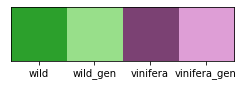

In [35]:
colours = sns.color_palette('tab20', 6)[4:]
colours.append(sns.color_palette('tab20b', 18)[16])
colours.append(sns.color_palette('tab20b', 20)[19])

ordered_labels = ('wild','wild_gen','vinifera','vinifera_gen')
label_colors = {lbl: c for lbl, c in zip(ordered_labels, colours)}

sns.palplot(label_colors.values())
new_ticks = plt.xticks(range(len(ordered_labels)), ordered_labels)

## Comparing Linearly Generated Samples with Real Samples

### Histograms
 
Histograms of values of Real Data and Linearly Generated Data (after pre-treatment) and histograms of number of peaks per sample on feature occurrence real data and linearly generated data. See details on number of peaks per sample in feature occurrence real and linearly generated data too.

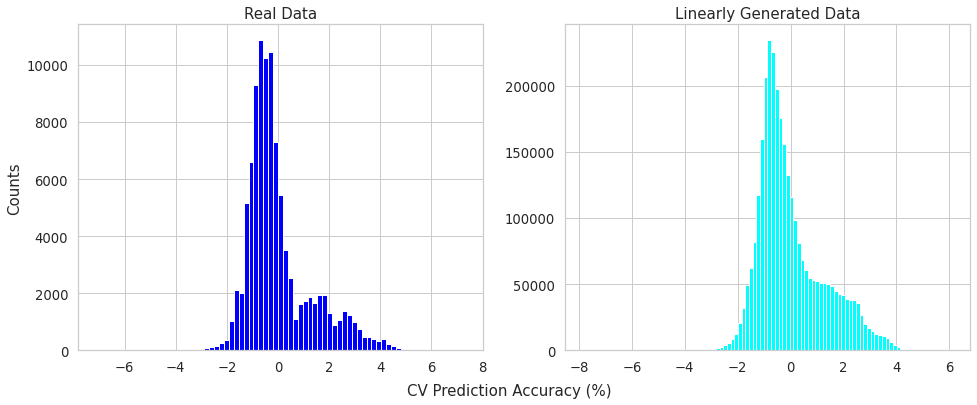

In [36]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        n_bins = 34
        axl.hist(datasets['vitis_types']['NGP'].values.flatten(), bins=75, color='blue')
        axl.set_title('Real Data', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        axr.hist(data_NGP.values.flatten(), bins=100, color='cyan')
        axr.set_title('Linearly Generated Data', fontsize=15)

    f.text(0.5, 0.05, 'CV Prediction Accuracy (%)', ha='center', va='top', fontsize=15)

In [37]:
print('Average value of feature in real data:     ', datasets['vitis_types']['NGP'].values.flatten().mean(), 
      '\t Standard Deviation of feature values in real data:     ', datasets['vitis_types']['NGP'].values.flatten().std())
print('Average value of feature in generated data:', data_NGP.values.flatten().mean(), 
      '\t Standard Deviation of feature values in real data:     ', data_NGP.values.flatten().std())


print('\nMedian value of feature in real data:     ', np.median(datasets['vitis_types']['NGP'].values.flatten()), 
      ' Median value of feature in generated data:', np.median(data_NGP.values.flatten()))

Average value of feature in real data:      -1.6171831661877763e-16 	 Standard Deviation of feature values in real data:      1.2858020130866499
Average value of feature in generated data: -2.2538720201487383e-15 	 Standard Deviation of feature values in real data:      1.2681029630437897

Median value of feature in real data:      -0.36021752536510643  Median value of feature in generated data: -0.3605347866358719


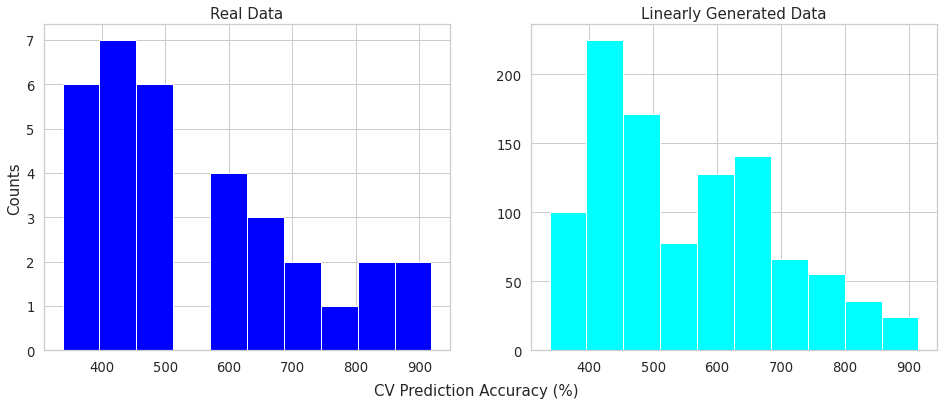

In [38]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        n_bins = 34
        axl.hist(datasets['vitis_types']['BinSim'].sum(axis=1), bins=10, color='blue')
        axl.set_title('Real Data', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        axr.hist(data_bin.sum(axis=1), bins=10, color='cyan')
        axr.set_title('Linearly Generated Data', fontsize=15)

    f.text(0.5, 0.05, 'CV Prediction Accuracy (%)', ha='center', va='top', fontsize=15)

In [39]:
print('Maximum nº of samples of real data:     ', datasets['vitis_types']['BinSim'].sum(axis=1).max(), 
      '\t Minimum nº of samples of real data:     ', datasets['vitis_types']['BinSim'].sum(axis=1).min())
print('Maximum nº of samples of generated data:', data_bin.sum(axis=1).max(), 
      '\t Minimum nº of samples of generated data:     ', data_bin.sum(axis=1).min())


print('\nAverage nº of samples of real data:     ', round(datasets['vitis_types']['BinSim'].sum(axis=1).mean(),2), 
      ' Average nº of samples of generated data:', round(data_bin.sum(axis=1).mean(),2))

Maximum nº of samples of real data:      919.0 	 Minimum nº of samples of real data:      338.0
Maximum nº of samples of generated data: 915.0 	 Minimum nº of samples of generated data:      338.0

Average nº of samples of real data:      547.27  Average nº of samples of generated data: 553.24


### PCA Representation of Real and Generated Data (both Intensity and Feature Occurrence Data)

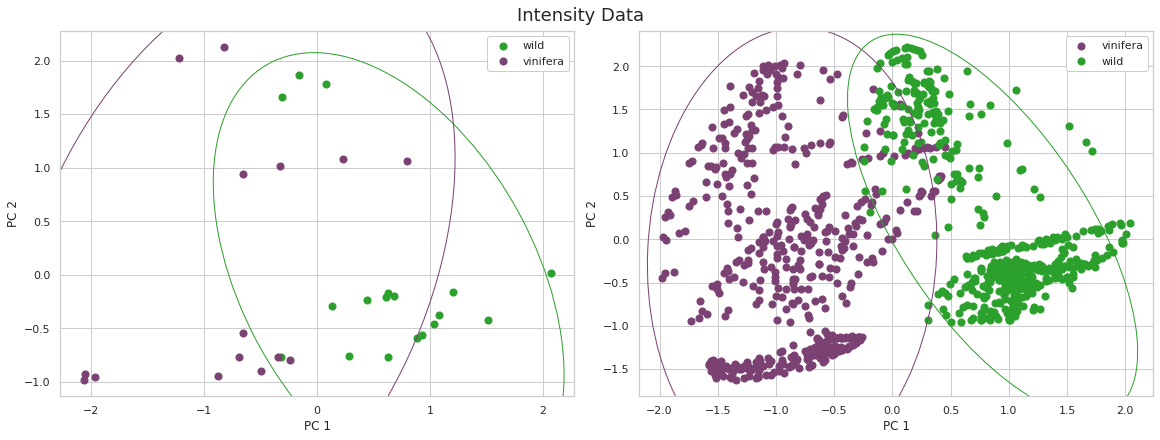

In [42]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)

        df = datasets['vitis_types']['NGP']
        labels = datasets['vitis_types']['target']
        #tf = transf.FeatureScaler(method='standard')
        #df = tf.fit_transform(df)
        principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
        lcolors = label_colors
        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axl)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=axl, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        df = data_NGP
        labels = lbls#['gen_' + i for i in lbls]
        #tf = transf.FeatureScaler(method='standard')
        #df = tf.fit_transform(df)
        principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
        lcolors = label_colors
        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)
        
        plt.suptitle('Intensity Data', fontsize=18)

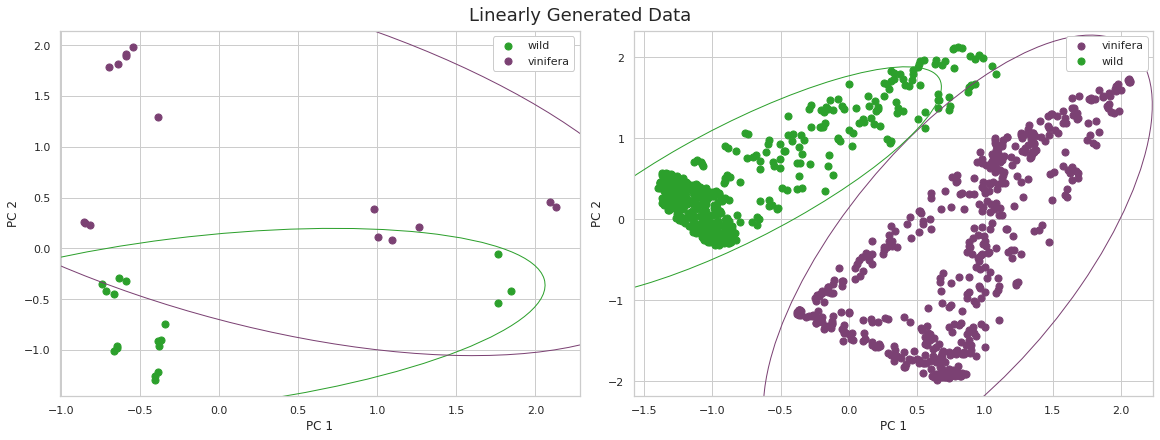

In [43]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)

        df = datasets['vitis_types']['BinSim']
        labels = datasets['vitis_types']['target']
        #tf = transf.FeatureScaler(method='standard')
        #df = tf.fit_transform(df)
        principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
        lcolors = label_colors
        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axl)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=axl, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        
        df = data_bin
        labels = lbls_bin#['gen_' + i for i in lbls_bin]
        #tf = transf.FeatureScaler(method='standard')
        #df = tf.fit_transform(df)
        principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
        lcolors = label_colors
        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)
        
        plt.suptitle('Linearly Generated Data', fontsize=18)

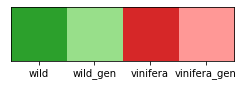

In [46]:
# Joined DFs but starting with linearly generated data
joined_dfs_rev = pd.concat([data_NGP, datasets['vitis_types']['NGP']])
joined_dfs_bin_rev = pd.concat([data_bin, datasets['vitis_types']['BinSim']])
joined_dfs
joined_labels_rev = [i + '_gen' for i in lbls] + datasets['vitis_types']['target'].copy()

colours2 = sns.color_palette('tab20', 10)[4:8]

ordered_labels_test = ('wild','wild_gen','vinifera','vinifera_gen')
label_colors_test = {lbl: c for lbl, c in zip(ordered_labels_test, colours2)}

sns.palplot(label_colors_test.values())
new_ticks_test = plt.xticks(range(len(ordered_labels_test)), ordered_labels_test)

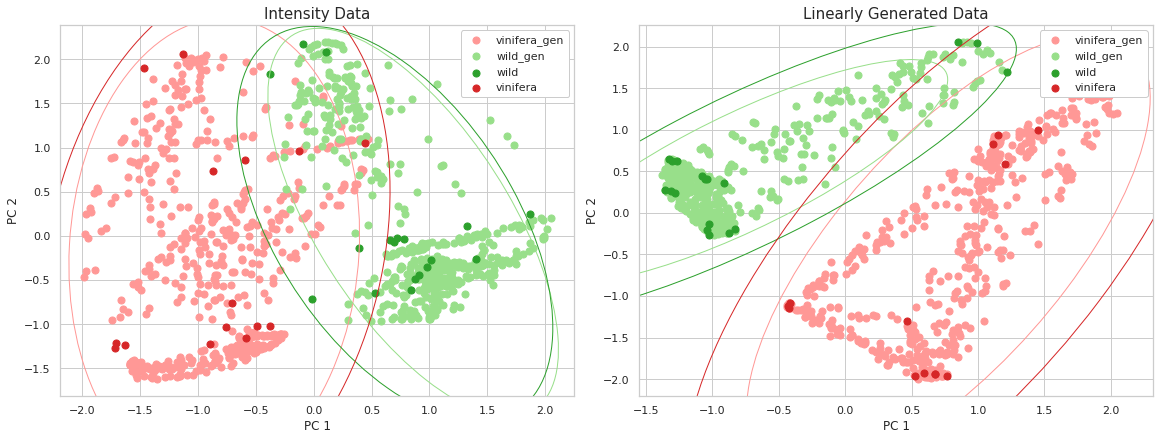

In [47]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)

        df = joined_dfs_rev
        labels = joined_labels_rev
        #tf = transf.FeatureScaler(method='standard')
        #df = tf.fit_transform(df)
        principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
        lcolors = label_colors_test
        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='Intensity Data', ax=axl)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=axl, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        
        df = joined_dfs_bin_rev
        labels = joined_labels_rev
        #tf = transf.FeatureScaler(method='standard')
        #df = tf.fit_transform(df)
        principaldf = ma.compute_df_with_PCs(df, n_components=2, whiten=True, labels=labels, return_var_ratios=False)
        lcolors = label_colors_test
        gem.plot_PCA(principaldf, lcolors, components=(1,2), title='Linearly Generated Data', ax=axr)
        gem.plot_ellipses_PCA(principaldf, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)

### tSNE plots of Real and Generated Data (both Intensity and Feature Occurrence Data)

In [48]:
from sklearn.manifold import TSNE

In [49]:
X = datasets['vitis_types']['NGP'].copy()
original_NGP_embedded = TSNE(n_components=2, perplexity=15, learning_rate='auto',
                  init='random', verbose=1).fit_transform(X)

[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 54.475932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.148212
[t-SNE] KL divergence after 1000 iterations: 0.098283


In [50]:
X = data_NGP
generated_NGP_embedded = TSNE(n_components=2, perplexity=40, learning_rate='auto',
                  init='random', verbose=1).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.031s...
[t-SNE] Computed neighbors for 1024 samples in 0.923s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 23.871984
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.360649
[t-SNE] KL divergence after 1000 iterations: 0.445034


In [51]:
X = datasets['vitis_types']['BinSim'].copy()
original_BinSim_embedded = TSNE(n_components=2, perplexity=15, learning_rate='auto',
                  init='random', verbose=1).fit_transform(X)

[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.016s...
[t-SNE] Computed neighbors for 33 samples in 0.031s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 14.346083
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.071720
[t-SNE] KL divergence after 1000 iterations: 0.097900


In [52]:
X = data_bin
generated_BinSim_embedded = TSNE(n_components=2, perplexity=40, learning_rate='auto',
                  init='random', verbose=1).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1024 samples in 0.029s...
[t-SNE] Computed neighbors for 1024 samples in 0.919s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1024
[t-SNE] Computed conditional probabilities for sample 1024 / 1024
[t-SNE] Mean sigma: 6.172109
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.738834
[t-SNE] KL divergence after 1000 iterations: 0.426823


In [53]:
X = joined_dfs
joined_NGP_embedded = TSNE(n_components=2, perplexity=40, learning_rate='auto',
                  init='random', verbose=1).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1057 samples in 0.028s...
[t-SNE] Computed neighbors for 1057 samples in 1.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1057
[t-SNE] Computed conditional probabilities for sample 1057 / 1057
[t-SNE] Mean sigma: 23.577001
[t-SNE] KL divergence after 250 iterations with early exaggeration: 56.696682
[t-SNE] KL divergence after 1000 iterations: 0.465653


In [54]:
X = joined_dfs_bin
joined_BinSim_embedded = TSNE(n_components=2, perplexity=40, learning_rate='auto',
                  init='random', verbose=1).fit_transform(X)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1057 samples in 0.031s...
[t-SNE] Computed neighbors for 1057 samples in 1.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1057
[t-SNE] Computed conditional probabilities for sample 1057 / 1057
[t-SNE] Mean sigma: 6.218368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.514885
[t-SNE] KL divergence after 1000 iterations: 0.422190


[t-SNE] Computing 32 nearest neighbors...
[t-SNE] Indexed 33 samples in 0.000s...
[t-SNE] Computed neighbors for 33 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 33 / 33
[t-SNE] Mean sigma: 54.475932
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.077209
[t-SNE] KL divergence after 1000 iterations: 0.046211


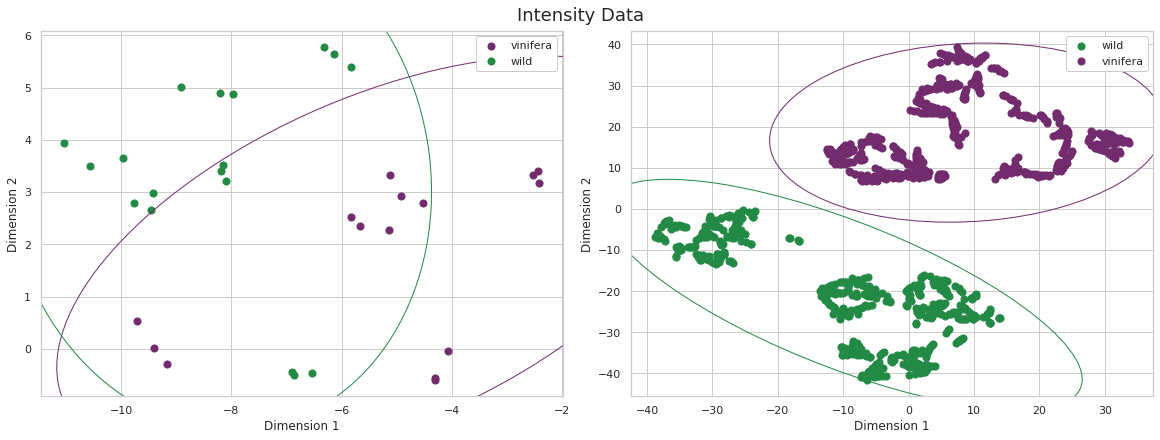

In [55]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)
        X = datasets['vitis_types']['NGP'].copy()
        original_NGP_embedded = TSNE(n_components=2, perplexity=15, learning_rate='auto',
                      init='random', verbose=1).fit_transform(X)

        df = original_NGP_embedded
        labels = datasets['vitis_types']['target']
        lcolors = datasets['vitis_types']['label_colors']
        gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axl)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axl, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        df = generated_NGP_embedded
        labels = lbls
        lcolors = datasets['vitis_types']['label_colors']
        gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)
        
        plt.suptitle('Intensity Data', fontsize=18)

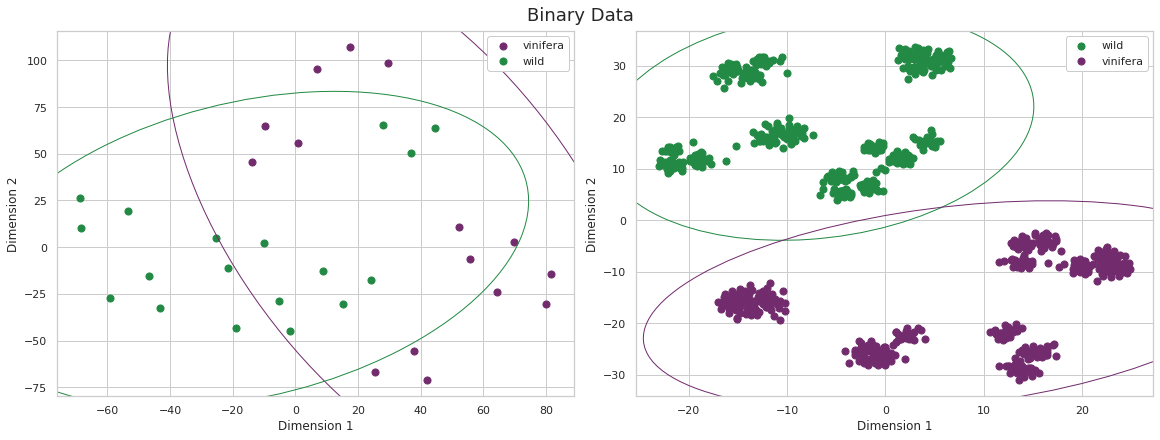

In [57]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)

        df = original_BinSim_embedded
        labels = datasets['vitis_types']['target']
        lcolors = datasets['vitis_types']['label_colors']
        gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axl)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axl, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        df = generated_BinSim_embedded
        labels = lbls
        lcolors = datasets['vitis_types']['label_colors']
        gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)
        
        plt.suptitle('Binary Data', fontsize=18)

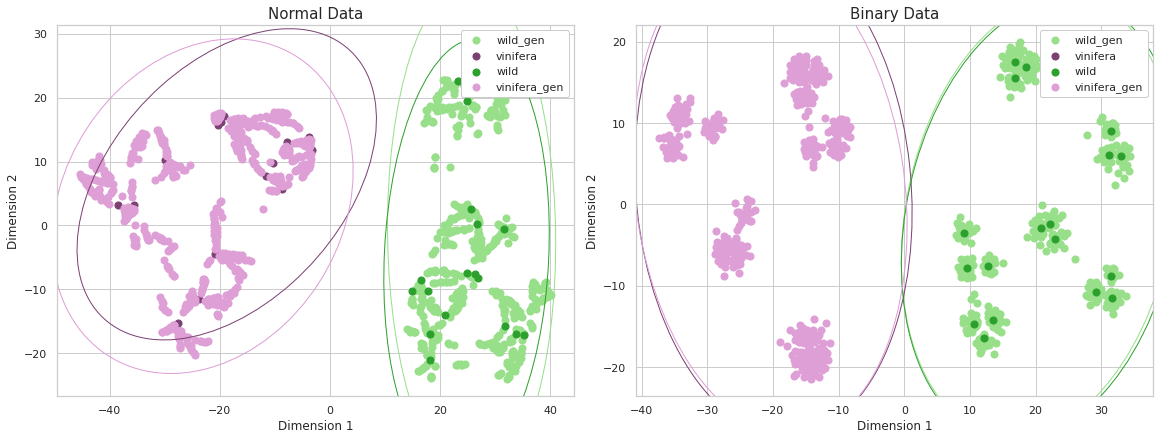

In [58]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1):
        f, (axl,axr) = plt.subplots(1,2, figsize=(16,6), constrained_layout=True)

        df = joined_NGP_embedded
        labels = joined_labels
        lcolors = label_colors
        gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='Normal Data', ax=axl)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axl, q=0.95)
        axl.legend(loc='upper right', ncol=1, framealpha=1)
        
        df = joined_BinSim_embedded
        labels = joined_labels
        lcolors = label_colors
        gem.plot_tSNE(df, labels, lcolors, components=(1,2), title='Binary Data', ax=axr)
        gem.plot_ellipses_tSNE(df, labels, lcolors, components=(1,2),ax=axr, q=0.95)
        axr.legend(loc='upper right', ncol=1, framealpha=1)

### Correlations between samples (Intensity Data)

In [59]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['NGP'], datasets['vitis_types']['NGP'],
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')
correlation_real_gen = gem.create_sample_correlations(datasets['vitis_types']['NGP'], data_NGP,
                                                   method='pearson')
print('Correlation Real-Generated calculation ended.')
correlation_gen_gen = gem.create_sample_correlations(data_NGP, data_NGP,
                                                   method='pearson')
print('Correlation Generated-Generated calculation ended.')

Correlation Real-Real calculation ended.
Correlation Real-Generated calculation ended.
Correlation Generated-Generated calculation ended.


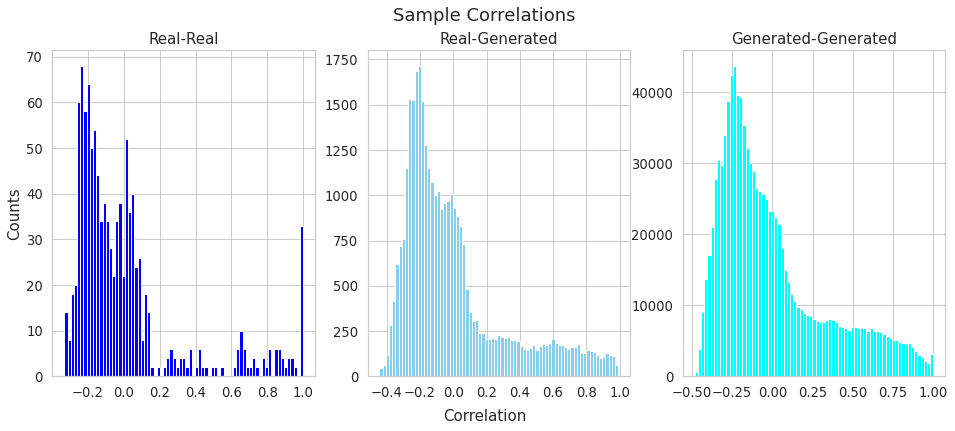

In [60]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axc, axr) = plt.subplots(1, 3, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.hist(correlation_real_real.values.flatten(), bins=75, color='blue')
        axl.set_title('Real-Real', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axc.hist(correlation_real_gen.values.flatten(), bins=75, color='skyblue')
        axc.set_title('Real-Generated', fontsize=15)
        
        axr.hist(correlation_gen_gen.values.flatten(), bins=75, color='cyan')
        axr.set_title('Generated-Generated', fontsize=15)
        
        plt.suptitle('Sample Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Number of samples per feature distribution (Feature Occurrence Data)

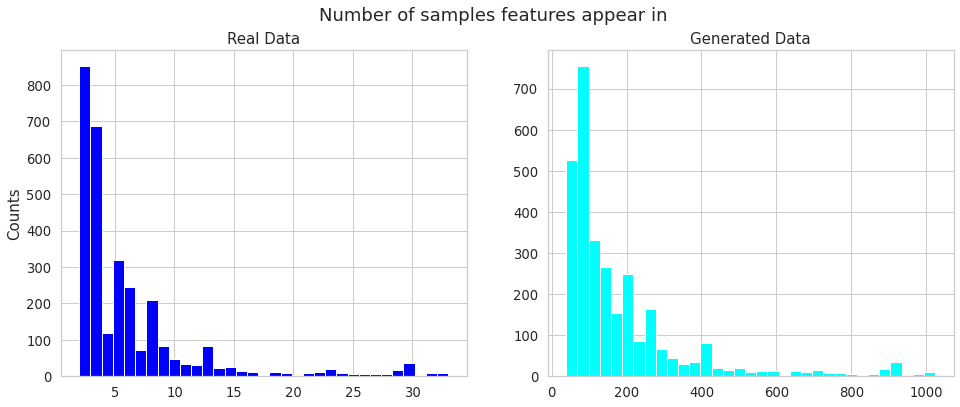

In [61]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.hist(datasets['vitis_types']['BinSim'].sum(axis=0), bins=33, color='blue')
        axl.set_title('Real Data', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axr.hist(data_bin.sum(axis=0), bins=33, color='cyan')
        axr.set_title('Generated Data', fontsize=15)
        
        plt.suptitle('Number of samples features appear in', fontsize=18)

### Correlations between features (Intensity Data)

In [ ]:
correlation_real_real = gem.create_sample_correlations(datasets['vitis_types']['NGP'].T, datasets['vitis_types']['NGP'].T,
                                                   method='pearson')
print('Correlation Real-Real calculation ended.')

correlation_gen_gen = gem.create_sample_correlations(data_NGP.T, data_NGP.T,
                                                   method='pearson')
print('Correlation Generated-Generated calculation ended.')

Correlation Real-Real calculation ended.


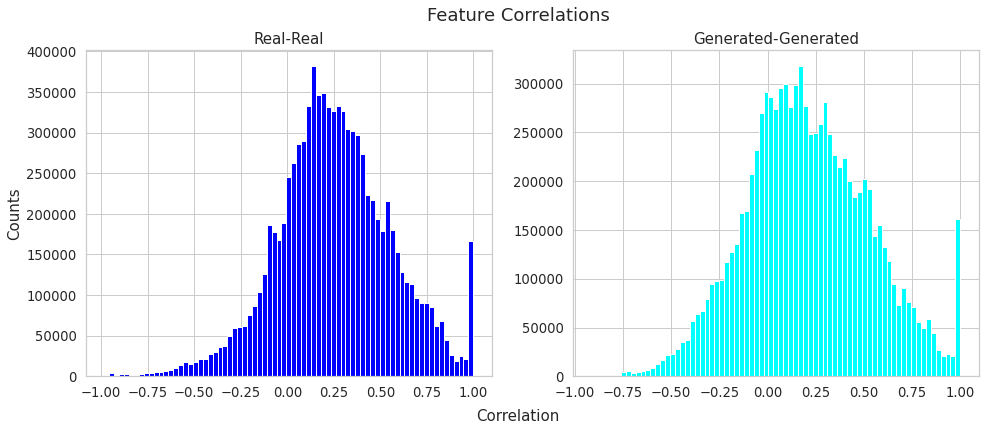

In [79]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.hist(correlation_real_real.values.flatten(), bins=75, color='blue')
        axl.set_title('Real-Real', fontsize=15)
        axl.set_ylabel('Counts', fontsize=15)
        
        axr.hist(correlation_gen_gen.values.flatten(), bins=75, color='cyan')
        axr.set_title('Generated-Generated', fontsize=15)
        
        plt.suptitle('Feature Correlations', fontsize=18)

    f.text(0.5, 0.05, 'Correlation', ha='center', va='top', fontsize=15)

### Characterizing generated datasets - Intensity Data

In [70]:
def characterize_data(dataset, name='dataset', target=None):
    "Returns some basic characteristics about the dataset."
    
    characteristics = {}
    
    n_samples, n_feats = dataset.shape
    
    if target:
        n_classes = len(np.unique(target))
        Samp_Class = len(target)/len(np.unique(target)) # Nº Sample per Class
    
    avg_feature_value = dataset.values.flatten().mean() # Mean value in the dataset
    max_feature_value = dataset.values.flatten().max() # Maximum value in the dataset
    min_feature_value = dataset.values.flatten().min() # Minimum value in the dataset
    std_feature_value = dataset.values.flatten().std() # Standard Deviation value in the dataset
    median_feature_value = np.median(dataset.values.flatten()) # Median value in the dataset
    
    if target:
        return {'Dataset': name,
                '# samples': n_samples,
                '# features': n_feats,
                'feature value average (std)': f'{avg_feature_value} ({std_feature_value})',
                'feature value ranges': f'({min_feature_value} - {max_feature_value})',
                'feature value median': median_feature_value,
                '# classes': n_classes,
                'samples / class': Samp_Class,
                } 
    else:
        return {'Dataset': name,
                '# samples': n_samples,
                '# features': n_feats,
                'Feature value average (std)': f'{avg_feature_value} ({std_feature_value})',
                'Feature value ranges': f'({min_feature_value} - {max_feature_value})',
                'Feature value median': median_feature_value,
                } 

In [71]:
names = ['Real data', 'Linearly Generated data']
data_repo = [datasets['vitis_types']['NGP'], data_NGP]
tgs = [datasets['vitis_types']['target'], lbls]
data_characteristics = [characterize_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]
data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,feature value average (std),feature value ranges,feature value median,# classes,samples / class
Dataset,,,,,,,
Real data,33,3025,-1.6171831661877763e-16 (1.2858020130866499),(-7.114287147421982 - 7.310759295422216),-0.360218,2,16.5
Linearly Generated data,1024,3025,-2.2538720201487383e-15 (1.2681029630437897),(-7.845091256924552 - 6.096765453559396),-0.360535,2,512.0


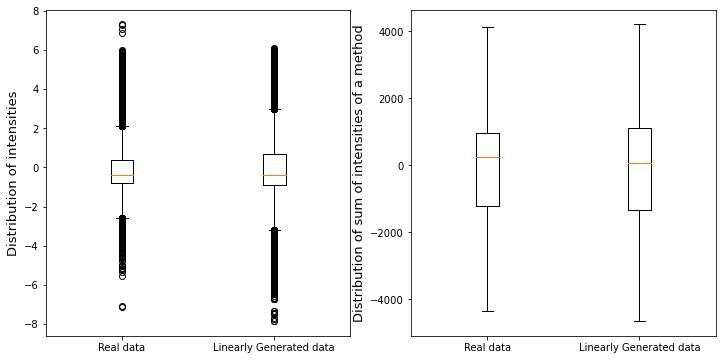

In [72]:
f, (axl, axr) = plt.subplots(1,2, figsize=(12,6))

axl.boxplot([ds.values.flatten() for ds in data_repo])
axl.set_ylabel('Distribution of intensities', fontsize=13)
axl.set_xticklabels(names)

axr.boxplot([ds.sum(axis=1) for ds in data_repo])
axr.set_ylabel('Distribution of sum of intensities of a method', fontsize=13)
axr.set_xticklabels(names)

plt.show()

### Characterizing generated datasets - Feature Occurrence Data

In [73]:
def characterize_binary_data(dataset, name='dataset', target=None):
    "Returns some basic characteristics about the dataset."
    
    n_samples, n_feats = dataset.shape
    
    if target:
        n_classes = len(np.unique(target))
        Samp_Class = len(target)/len(np.unique(target)) # Number of Sample per Class
    
    max_n_features = dataset.sum(axis=1).max() # Nº of features of sample with the most features
    min_n_features = dataset.sum(axis=1).min() # Nº of features of sample with the least features
    avg_n_features = round(dataset.sum(axis=1).mean(),2) # Average number of features of a sample
    std_n_features = round(dataset.sum(axis=1).std(),2) # Standard Deviation of the number of features per sample
    median_n_features = np.median(dataset.sum(axis=1)) # Median number of features of a sample
    
    min_n_samples = dataset.sum(axis=0).min() # Minimum nº of samples a feature appears
    max_n_samples = dataset.sum(axis=0).max() # Maximum nº of samples a feature appears
    avg_n_samples = round(dataset.sum(axis=0).mean(),2) # Average number of samples a feature appears in
    std_n_samples = round(dataset.sum(axis=0).std(),2) # Standard Deviation of the number of samples a feature appears in
    
    if target:
        return {'Dataset': name,
                '# samples': n_samples,
                '# features': n_feats,
                'average # of features per sample (std)': f'{avg_n_features} ({std_n_features})',
                '# features per sample ranges': f'({min_n_features} - {max_n_features})',
                '# features per sample median': median_n_features,
                'average # of times feature appear in sample (std)': f'{avg_n_samples} ({std_n_samples})',
                'min and max # of times a feature appears in a sample': f'{min_n_samples} - {max_n_samples}',
                '# classes': n_classes,
                'samples / class': Samp_Class,
                } 
    else:
        return {'Dataset': name,
                '# samples': n_samples,
                '# features': n_feats,
                'average # of features per sample (std)': f'{avg_n_features} ({std_n_features})',
                '# features per sample ranges': f'({min_n_features} - {max_n_features})',
                '# features per sample median': median_n_features,
                'average # of times feature appear in sample (std)': f'{avg_n_samples} ({std_n_samples})',
                'min and max # of times a feature appears in a sample': f'{min_n_samples} - {max_n_samples}',
                } 

In [74]:
names = ['Real data', 'Linearly Generated data']
data_repo = [datasets['vitis_types']['BinSim'], data_bin]
tgs = [datasets['vitis_types']['target'], lbls]
data_characteristics = [characterize_binary_data(ds, name, tg) for ds,name,tg in zip(data_repo, names, tgs)]

data_characteristics = pd.DataFrame(data_characteristics).set_index('Dataset')
data_characteristics

,# samples,# features,average # of features per sample (std),# features per sample ranges,# features per sample median,average # of times feature appear in sample (std),min and max # of times a feature appears in a sample,# classes,samples / class
Dataset,,,,,,,,,
Real data,33,3026,547.27 (167.29),(338.0 - 919.0),479.0,5.97 (5.92),2.0 - 33.0,2,16.5
Linearly Generated data,1024,3026,553.24 (136.49),(338.0 - 915.0),521.0,187.22 (182.09),39.0 - 1024.0,2,512.0


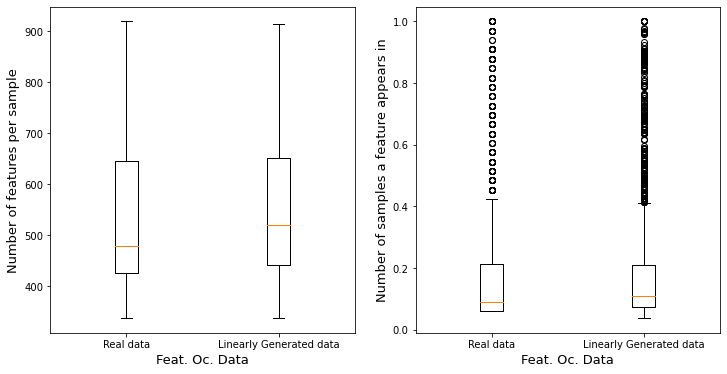

In [75]:
f, (axl, axr) = plt.subplots(1,2, figsize=(12,6))

axl.boxplot([ds.sum(axis=1) for ds in data_repo])
axl.set_xlabel('Feat. Oc. Data', fontsize=13)
axl.set_ylabel('Number of features per sample', fontsize=13)
axl.set_xticklabels(names)

axr.boxplot([ds.sum(axis=0)/len(ds) for ds in data_repo])
axr.set_xlabel('Feat. Oc. Data', fontsize=13)
axr.set_ylabel('Number of samples a feature appears in', fontsize=13)
axr.set_xticklabels(names)

plt.show()

## See which SciPy distribution best fits the real intensities distributions (after pre-treatment) 

This is done to generate the initial inputs to give to the Generator neural network model of the Generative Adversarial Network made later to generate artificial metabolomics samples.

In [76]:
hist = np.histogram(datasets['vitis_types']['NGP'].values.flatten(), bins=100)
hist_dist = stats.rv_histogram(hist)

In [77]:
def fitting_distributions(data, bins=150):
    
    # Generating a histogram (with probability as y's) and storing the relevant coordinates
    hist_ys, hist_edge_xs = np.histogram(data, bins=bins, density=True)
    hist_xs = (hist_edge_xs[:-1] + hist_edge_xs[1:]) / 2.0 # Get the center of each  histogram column instead of the edges
    
    # Store the results
    dist_results = {}
    # Get all distributions in scipy
    distributions = [d for d in dir(stats) if isinstance(getattr(stats, d), stats.rv_continuous)] 
    
    for dist in distributions:
        # Remove some distributions that might give some 'trouble'. It is not an issue, we are testing 90+ distributions.
        if dist in ['erlang', 'invweibull', 'ksone', 'kstwo', 'levy_stable', 'studentized_range', 'tukeylambda',
                   'vonmises']:
            continue

        dist_results[dist] = {}
        print(dist)

        stats_dist = getattr(stats, dist)

        parameters = stats_dist.fit(data)

        # Separate parts of parameters
        shapes = parameters[:-2]
        loc = parameters[-2]
        scale = parameters[-1]

        # Calculate fitted PDF and error with fit in distribution
        pdf = stats_dist.pdf(hist_xs, loc=loc, scale=scale, *shapes)
        cdf = stats_dist.cdf(hist_xs, loc=loc, scale=scale, *shapes)
        sse = np.sum((hist_ys-pdf)**2)

        dist_results[dist]['parameters'] = parameters
        dist_results[dist]['hist_xs'] = hist_xs
        dist_results[dist]['pdf'] = pdf
        dist_results[dist]['cdf'] = cdf
        dist_results[dist]['sse'] = sse
        
    return dist_results


In [58]:
GENERATE = True
if GENERATE:
    dist_results_real = fitting_distributions(datasets['vitis_types']['NGP'].values.flatten(), bins=100)
    np.save('store_data/dist_results_real', dist_results_real)
dist_results_real = np.load('store_data/dist_results_real.npy',allow_pickle='TRUE').item()

In [59]:
pd.DataFrame(dist_results_real).T.sort_values(axis=0, by='sse', ascending=True).index

Index(['norminvgauss', 'johnsonsu', 'skewcauchy', 'nct', 'burr12', 'cauchy',
       't', 'loglaplace', 'exponnorm', 'mielke', 'burr', 'laplace', 'fisk',
       'genextreme', 'gumbel_r', 'skewnorm', 'alpha', 'moyal', 'exponweib',
       'invgamma', 'geninvgauss', 'logistic', 'lognorm', 'johnsonsb',
       'invgauss', 'fatiguelife', 'recipinvgauss', 'weibull_max',
       'genhyperbolic', 'pearson3', 'gengamma', 'beta', 'gamma',
       'vonmises_line', 'nakagami', 'chi', 'gausshyper', 'genlogistic',
       'dweibull', 'dgamma', 'hypsecant', 'gennorm', 'crystalball', 'norm',
       'rdist', 'truncnorm', 'loggamma', 'powernorm', 'laplace_asymmetric',
       'weibull_min', 'kstwobign', 'gompertz', 'gumbel_l', 'exponpow',
       'cosine', 'triang', 'maxwell', 'rice', 'anglit', 'ncx2', 'betaprime',
       'semicircular', 'genhalflogistic', 'kappa3', 'halfgennorm', 'argus',
       'wald', 'genexpon', 'halflogistic', 'powerlaw', 'uniform', 'wrapcauchy',
       'powerlognorm', 'gilbrat', 'kappa4'

In [60]:
GENERATE = True
if GENERATE:
    dist_results_generated = fitting_distributions(data_NGP.values.flatten(), bins=150)
    np.save('store_data/dist_results_generated', dist_results_generated)
dist_results_generated = np.load('store_data/dist_results_generated.npy',allow_pickle='TRUE').item()

In [61]:
pd.DataFrame(dist_results_generated).T.sort_values(axis=0, by='sse', ascending=True).index

Index(['skewcauchy', 'johnsonsu', 'nct', 'burr12', 'exponnorm', 'norminvgauss',
       'mielke', 'cauchy', 'skewnorm', 'burr', 'gumbel_r', 'loglaplace',
       'weibull_max', 'alpha', 'fisk', 'laplace', 'exponweib', 'invgamma',
       'betaprime', 'lognorm', 'fatiguelife', 'recipinvgauss', 'invgauss',
       'johnsonsb', 't', 'pearson3', 'chi2', 'gamma', 'ncx2', 'logistic',
       'chi', 'nakagami', 'vonmises_line', 'genhyperbolic', 'norm',
       'crystalball', 'rdist', 'gennorm', 'truncnorm', 'genlogistic',
       'loggamma', 'moyal', 'powernorm', 'hypsecant', 'dweibull', 'dgamma',
       'genextreme', 'laplace_asymmetric', 'weibull_min', 'beta', 'gumbel_l',
       'gompertz', 'gausshyper', 'kstwobign', 'triang', 'cosine', 'f',
       'exponpow', 'maxwell', 'geninvgauss', 'anglit', 'rice', 'argus',
       'semicircular', 'genhalflogistic', 'powerlognorm', 'kappa3',
       'genpareto', 'powerlaw', 'ncf', 'trapz', 'trapezoid', 'uniform',
       'bradford', 'wrapcauchy', 'wald', 'gengam

Representing Fitted Distributions and Intensities Distribution

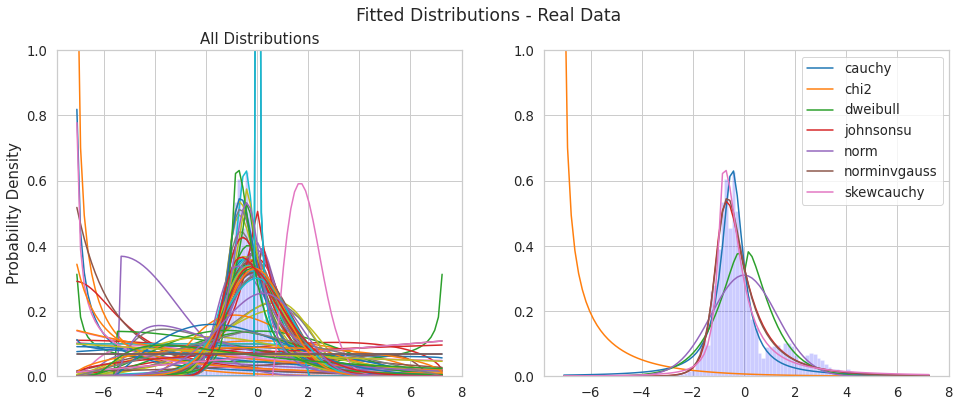

In [62]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')

        n_bins = 100
        axl.hist(datasets['vitis_types']['NGP'].values.flatten(), bins=100, color='blue', density=True, alpha=0.2)
        axr.hist(datasets['vitis_types']['NGP'].values.flatten(), bins=100, color='blue', density=True, alpha=0.2)

        axl.set_title('All Distributions', fontsize=15)
        axl.set_ylabel('Probability Density', fontsize=15)

        for i in dist_results_real:
            axl.plot(dist_results_real[i]['hist_xs'], dist_results_real[i]['pdf'], label=i)

            if i in ['norminvgauss', 'johnsonsu', 'skewcauchy', 'cauchy', 'dweibull', 'norm']:
                axr.plot(dist_results_real[i]['hist_xs'], dist_results_real[i]['pdf'], label=i)
        
        axr.set_title('Some of the Best Fitted Distributions', fontsize=15)

        axl.set_ylim([0,1])
        axr.set_ylim([0,1])
        axr.legend()
        
        plt.suptitle('Fitted Distributions - Real Data')

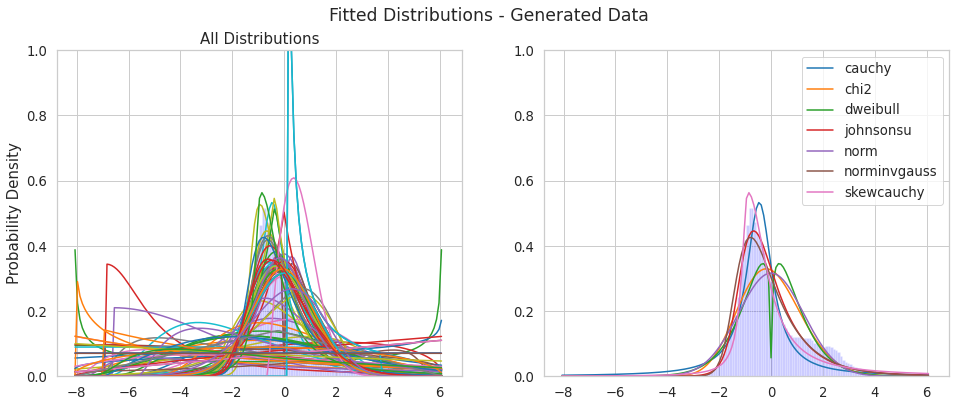

In [67]:
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (16,6))#, sharey='row')#, sharex='col')
        
        axl.hist(data_NGP.values.flatten(), bins=150, color='blue', density=True, alpha=0.2)
        axr.hist(data_NGP.values.flatten(), bins=150, color='blue', density=True, alpha=0.2)
        
        axl.set_title('All Distributions', fontsize=15)
        axl.set_ylabel('Probability Density', fontsize=15)
        
        for i in dist_results_real:
            axl.plot(dist_results_generated[i]['hist_xs'], dist_results_generated[i]['pdf'], label=i)
            
            if i in ['norminvgauss', 'johnsonsu', 'skewcauchy', 'chi2', 'cauchy', 'dweibull', 'norm']:
                axr.plot(dist_results_generated[i]['hist_xs'], dist_results_generated[i]['pdf'], label=i)
                
        axr.set_title('Some of the Best Fitted Distributions', fontsize=15)
            
        axl.set_ylim([0,1])
        axr.set_ylim([0,1])
        axr.legend()
        
        plt.suptitle('Fitted Distributions - Linearly Generated Data')

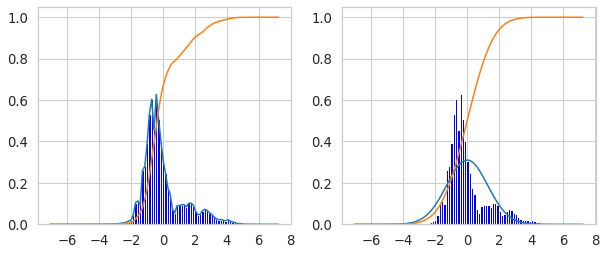

In [68]:
# Comparing cumulative density function of actual intensity distribution against a fitted normal distribution
with sns.axes_style("whitegrid"):
    with sns.plotting_context("notebook", font_scale=1.2):
        f, (axl, axr) = plt.subplots(1, 2, figsize = (10,4))#, sharey='row')#, sharex='col')
        X = dist_results_real['norm']['hist_xs']# np.linspace(-5.0, 5.0, 100)
        
        axl.hist(datasets['vitis_types']['NGP'].values.flatten(), bins=100, color='blue', density=True)
        axl.plot(X, hist_dist.pdf(X), label='PDF')
        axl.plot(X, hist_dist.cdf(X), label='CDF')
        
        axr.hist(datasets['vitis_types']['NGP'].values.flatten(), bins=100, color='blue', density=True)
        axr.plot(X, dist_results_real['norm']['pdf'], label='PDF')
        axr.plot(X, dist_results_real['norm']['cdf'], label='CDF')
        
plt.show()

### Testing making a distribution using both the real distribution of intensities and the best fitting distribution

In [69]:
hist = np.histogram(datasets['vitis_types']['NGP'].values.flatten(), bins=100)
input_realdata_dist = stats.rv_histogram(hist)

In [70]:
# Separate parts of parameters
shapes = dist_results_real['norminvgauss']['parameters'][:-2]
loc = dist_results_real['norminvgauss']['parameters'][-2]
scale = dist_results_real['norminvgauss']['parameters'][-1]
input_norminvgaussy_dist = stats.norminvgauss(a=shapes[0], b=shapes[1], loc=loc, scale=scale)